# Temperature Prediction

## Content

1. [Introduction](#1)
2. [The Data](#2)
3. [Exploratory Data Analysis](#3)
4. [Analysis](#4)
5. [Hyper Parameter Tuning](#5)
6. [Model Saving](#6)

## Introduction

Temperature prediction is needed for many organisation. New agencies need them to report weather conditions, weather agencies need them to predict weather conditions, etc. In this analysis, we will try to predict the maximum ans minimum temperature based on given inputs.

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import yeojohnson

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_transformer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## The Data <a name = '2'></a>

In [3]:
temperatureDf = pd.read_csv('temperature.csv')
temperatureDf.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,LDAPS_CC3,LDAPS_CC4,LDAPS_PPT1,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,30-06-2013,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,0.203896,0.161697,0.130928,0.0,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,30-06-2013,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,0.251771,0.159444,0.127727,0.0,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,30-06-2013,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,0.257469,0.204091,0.142125,0.0,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,30-06-2013,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,0.226002,0.161157,0.134249,0.0,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,30-06-2013,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,0.249995,0.178892,0.170021,0.0,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


In [4]:
temperatureDf.shape

(7752, 25)

The dataset has 7,752 rows and 25 columns. Out of these, Next_Tmax and Next_Tmin is the target column. Therefore, this is a multiple target regression problem.

## Exploratory Data Analysis <a name = '3'></a>

In [5]:
#Checking for null values
temperatureDf.isnull().sum()

station              2
Date                 2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
dtype: int64

Almost all columns have missing values.

In [6]:
#Checking how many rows have missing values
temperatureDf[temperatureDf.isnull().any(axis = 1)].shape

(164, 25)

There are 164 rows with missing values out of the total of 7752 rows.

In [7]:
#Checking missing row percentage
(164/7752)*100

2.1155830753353975

Since only 2.16% of rows have missing value, we will drop the rows with missing values.

In [8]:
temperatureDf.dropna(axis = 0, inplace = True)

In [9]:
temperatureDf.shape

(7588, 25)

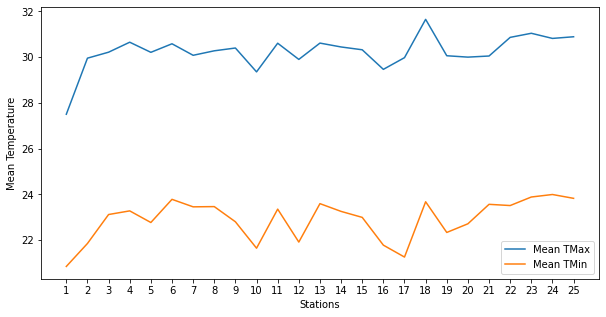

In [9]:
plt.figure(figsize = (10,5))
plt.plot(temperatureDf.groupby('station')['Next_Tmax'].mean(), label = 'Mean TMax')
plt.plot(temperatureDf.groupby('station')['Next_Tmin'].mean(), label = 'Mean TMin')
plt.xticks(temperatureDf['station'].unique())
plt.xlabel('Stations')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

We see that the mean TMax and TMin follow each other. For example, for station 18, the mean TMax has a upward spike. Corresponding to this spike, the mean TMin also has a spike for station 18.

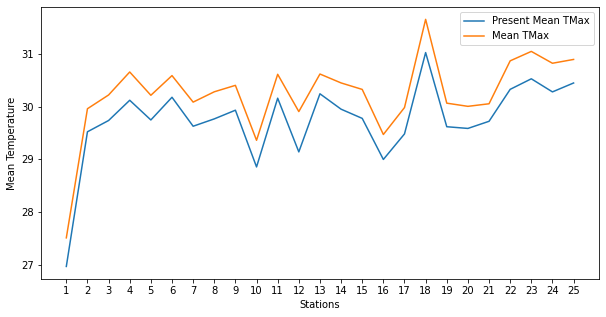

In [10]:
plt.figure(figsize = (10,5))
plt.plot(temperatureDf.groupby('station')['Present_Tmax'].mean(), label = 'Present Mean TMax')
plt.plot(temperatureDf.groupby('station')['Next_Tmax'].mean(), label = 'Mean TMax')
plt.xticks(temperatureDf['station'].unique())
plt.xlabel('Stations')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

We see that the present mean TMax and Next_TMax follow each other very closely as well. For example, for station 18, the present mean TMax has a upward spike. Corresponding to this spike, the mean Next_TMax also has a spike for station 18.

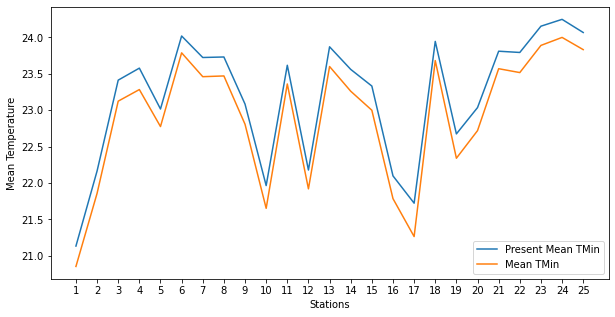

In [11]:
plt.figure(figsize = (10,5))
plt.plot(temperatureDf.groupby('station')['Present_Tmin'].mean(), label = 'Present Mean TMin')
plt.plot(temperatureDf.groupby('station')['Next_Tmin'].mean(), label = 'Mean TMin')
plt.xticks(temperatureDf['station'].unique())
plt.xlabel('Stations')
plt.ylabel('Mean Temperature')
plt.legend()
plt.show()

Like Present mean TMax and mean Next_TMax, Present mean TMin and mean Next_TMin also show the same behaviour.

<AxesSubplot:>

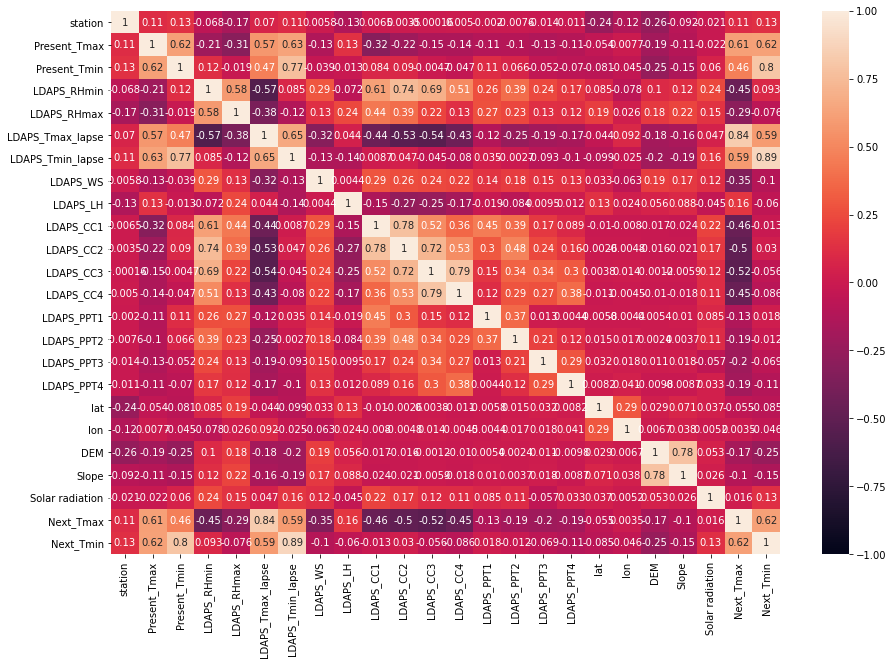

In [12]:
plt.figure(figsize = (15,10))
sns.heatmap(temperatureDf.corr(), vmax = 1, vmin = -1, annot = True)

In [13]:
#Making a list of feature columns without the date column
cols = temperatureDf.columns.to_list()[:23]
cols.remove('Date')

Preforming Pearson correlation test of significance for both the target columns one-by-one.

In [14]:
#Making an empty list to store all columns with p-value less the 0.1
significantCols = []

#Calculating the pearson correlation cofficient and their p-values with respect to the target variable to see if they are
#statistically significant. If they are significant then we print those column's Pearson Correlation Coefficient and P-value
#and store the column names in the empty list initialised above
for index in range(len(cols)):
    pCoef, pVal = stats.pearsonr(temperatureDf[cols[index]], temperatureDf['Next_Tmax'])
    if pVal < 0.1:
        significantCols.append(cols[index])
        print(f'{cols[index]}:\n\tThe Pearson Correlation Coefficient:{pCoef}\n\tP-value: {pVal}')

station:
	The Pearson Correlation Coefficient:0.1077473544746193
	P-value: 4.884496630627575e-21
Present_Tmax:
	The Pearson Correlation Coefficient:0.6103566126678978
	P-value: 0.0
Present_Tmin:
	The Pearson Correlation Coefficient:0.4635229246116475
	P-value: 0.0
LDAPS_RHmin:
	The Pearson Correlation Coefficient:-0.44682410761997393
	P-value: 0.0
LDAPS_RHmax:
	The Pearson Correlation Coefficient:-0.28978792842700263
	P-value: 1.0233677034144296e-146
LDAPS_Tmax_lapse:
	The Pearson Correlation Coefficient:0.8357290284840966
	P-value: 0.0
LDAPS_Tmin_lapse:
	The Pearson Correlation Coefficient:0.5921189652231063
	P-value: 0.0
LDAPS_WS:
	The Pearson Correlation Coefficient:-0.35110688928740924
	P-value: 4.9538903564323924e-219
LDAPS_LH:
	The Pearson Correlation Coefficient:0.15677904612386379
	P-value: 5.8735286756678334e-43
LDAPS_CC1:
	The Pearson Correlation Coefficient:-0.4597046165221885
	P-value: 0.0
LDAPS_CC2:
	The Pearson Correlation Coefficient:-0.4982949006193063
	P-value: 0.0
LDA

In [15]:
#Making an empty list to store all columns with p-value less the 0.1
significantCols1 = []

#Calculating the pearson correlation cofficient and their p-values with respect to the target variable to see if they are
#statistically significant. If they are significant then we print those column's Pearson Correlation Coefficient and P-value
#and store the column names in the empty list initialised above
for index in range(len(cols)):
    pCoef, pVal = stats.pearsonr(temperatureDf[cols[index]], temperatureDf['Next_Tmin'])
    if pVal < 0.1:
        significantCols1.append(cols[index])
        print(f'{cols[index]}:\n\tThe Pearson Correlation Coefficient:{pCoef}\n\tP-value: {pVal}')

station:
	The Pearson Correlation Coefficient:0.12818405608169064
	P-value: 3.6240824864107195e-29
Present_Tmax:
	The Pearson Correlation Coefficient:0.6210484100356098
	P-value: 0.0
Present_Tmin:
	The Pearson Correlation Coefficient:0.7969747772262464
	P-value: 0.0
LDAPS_RHmin:
	The Pearson Correlation Coefficient:0.09324949215493068
	P-value: 3.9762677440910705e-16
LDAPS_RHmax:
	The Pearson Correlation Coefficient:-0.07641549084746249
	P-value: 2.644189923399691e-11
LDAPS_Tmax_lapse:
	The Pearson Correlation Coefficient:0.589963154129049
	P-value: 0.0
LDAPS_Tmin_lapse:
	The Pearson Correlation Coefficient:0.886512766638969
	P-value: 0.0
LDAPS_WS:
	The Pearson Correlation Coefficient:-0.10202125539455002
	P-value: 5.160147018375375e-19
LDAPS_LH:
	The Pearson Correlation Coefficient:-0.06039249517208743
	P-value: 1.4043648951403515e-07
LDAPS_CC2:
	The Pearson Correlation Coefficient:0.030357996291712604
	P-value: 0.008177970901130927
LDAPS_CC3:
	The Pearson Correlation Coefficient:-0.0

In [16]:
#Checking skewness
temperatureDf.skew()

station            -0.004178
Present_Tmax       -0.257069
Present_Tmin       -0.353822
LDAPS_RHmin         0.301396
LDAPS_RHmax        -0.845264
LDAPS_Tmax_lapse   -0.222349
LDAPS_Tmin_lapse   -0.574035
LDAPS_WS            1.553926
LDAPS_LH            0.662971
LDAPS_CC1           0.456716
LDAPS_CC2           0.473929
LDAPS_CC3           0.639649
LDAPS_CC4           0.663815
LDAPS_PPT1          5.305906
LDAPS_PPT2          5.710360
LDAPS_PPT3          6.356670
LDAPS_PPT4          6.681256
lat                 0.085377
lon                -0.289048
DEM                 1.721617
Slope               1.559050
Solar radiation    -0.524325
Next_Tmax          -0.334842
Next_Tmin          -0.393662
dtype: float64

The columns 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC3', 'LDAPS_CC4', 'Slope', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3',and  'LDAPS_PPT4' have skewness.

In [17]:
#Transforming columns with skewness
temperatureDf['LDAPS_WS'] = (temperatureDf['LDAPS_WS'])**(1/2)
temperatureDf['LDAPS_LH'] = (temperatureDf['LDAPS_LH'])**(1/2)
temperatureDf['LDAPS_CC3'] = (temperatureDf['LDAPS_CC3'])**(1/2)
temperatureDf['LDAPS_CC4'] = (temperatureDf['LDAPS_CC4'])**(1/2)
temperatureDf['Slope'] = (temperatureDf['Slope'])**(1/3)
temperatureDf['LDAPS_PPT1'] = yeojohnson(temperatureDf['LDAPS_PPT1'])[0]         
temperatureDf['LDAPS_PPT2'] = yeojohnson(temperatureDf['LDAPS_PPT2'])[0] 
temperatureDf['LDAPS_PPT3'] = yeojohnson(temperatureDf['LDAPS_PPT3'])[0]         
temperatureDf['LDAPS_PPT4'] = yeojohnson(temperatureDf['LDAPS_PPT4'])[0]

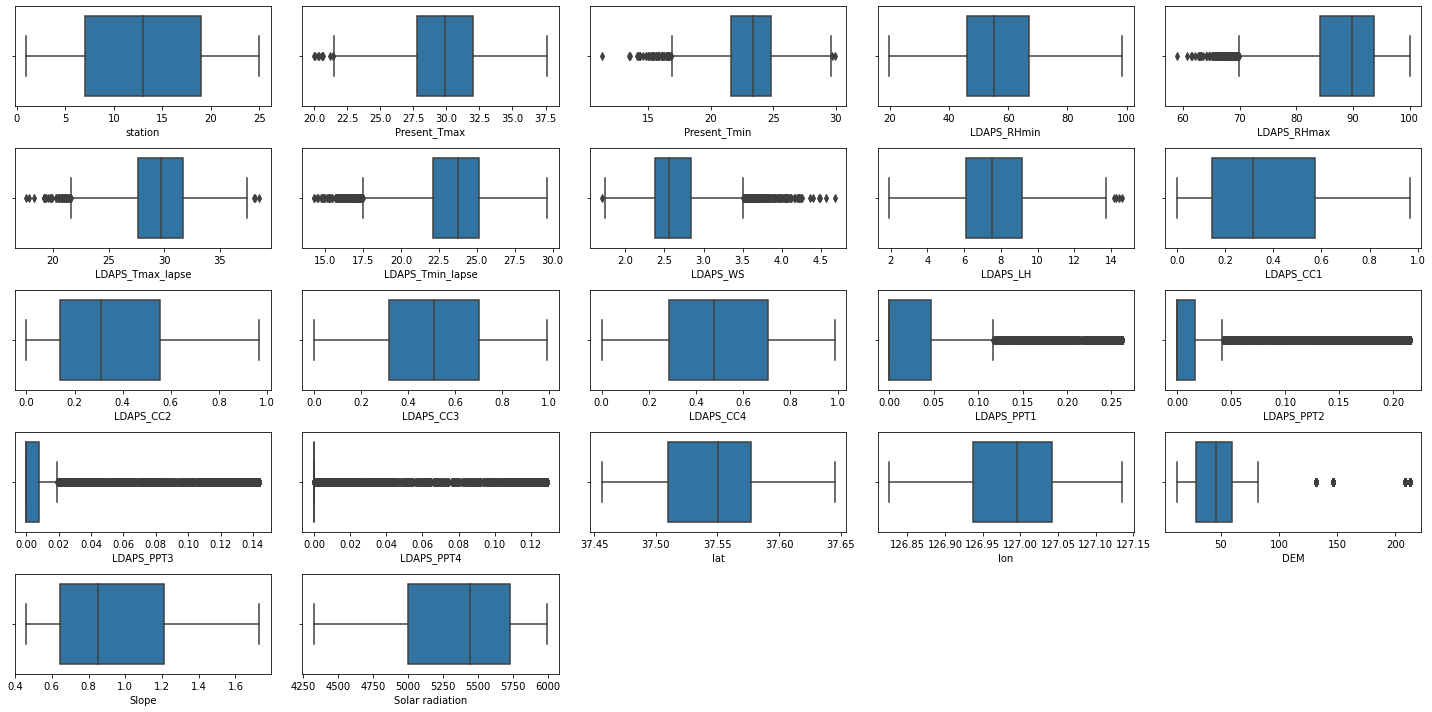

In [18]:
#Checking for outliers
plt.figure(figsize=(20,10))

for i in range(len(cols)):
    plt.subplot(5,5,i+1)
    sns.boxplot(temperatureDf[cols[i]])
    plt.tight_layout()

The columns 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', and 'DEM' have outliers and needs to be treated.

In [19]:
outlierCols = ['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
              'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'DEM']

#Making a function to detect outliers using the IQR method and then replacing them with the upper and lower bridge values
def outlierRemoverS(data, col):
    '''Note: This function is for skewed data only'''
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    lowerBridge = data[col].quantile(0.25) - (1.5*IQR)
    upperBridge = data[col].quantile(0.75) + (1.5*IQR)
    if lowerBridge >=0:
            data.loc[data[col]>=upperBridge, col] = upperBridge
            data.loc[data[col]<=lowerBridge, col] = lowerBridge
    elif lowerBridge < 0:
            data.loc[data[col]>=upperBridge, col] = upperBridge
            data.loc[data[col]<=0, col] = data[col].quantile(0.5)

In [20]:
#Applying the above function on each numeric columns to handle the outliers
for index in range(len(outlierCols)):
    outlierRemoverS(temperatureDf, outlierCols[index])

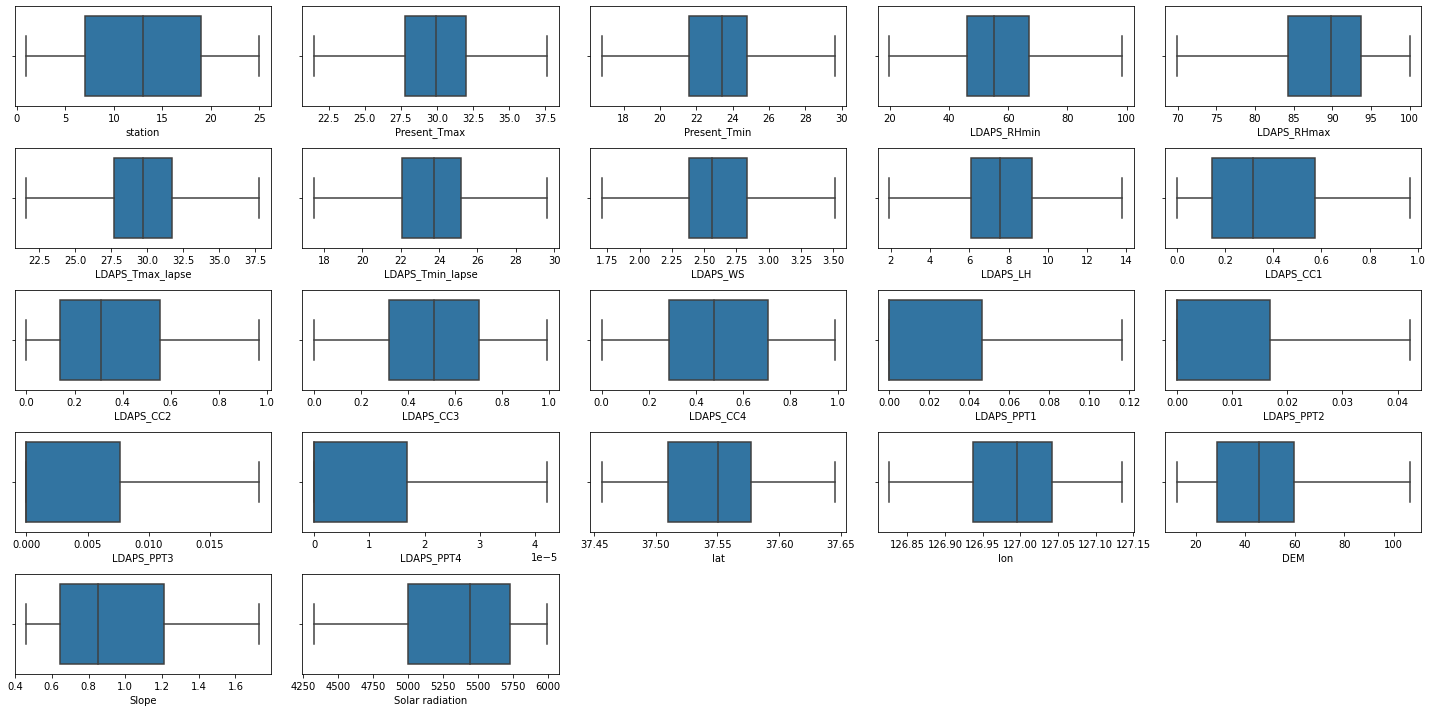

In [21]:
#COlumns after outlier removal
plt.figure(figsize=(20,10))

for i in range(len(cols)):
    plt.subplot(5,5,i+1)
    sns.boxplot(temperatureDf[cols[i]])
    plt.tight_layout()

In [22]:
#Dropping the date columns as it wont be needed.
temperatureDf.drop('Date', axis = 1, inplace = True)

## Analysis <a name = '4'></a>

In [44]:
#Seperating the features and target columns
x = temperatureDf.drop(['Next_Tmax', 'Next_Tmin'], axis = 1)
y = temperatureDf[['Next_Tmax', 'Next_Tmin']]

In [45]:
x = pd.get_dummies(temperatureDf, columns=['station'])

In [46]:
#making a column transformer to perform standard scaling on numeric columns and one hot encoding on categorical columns
colTrans = make_column_transformer((StandardScaler(), x.columns), remainder='passthrough') 
x = colTrans.fit_transform(x)
x = np.nan_to_num(x)

In [47]:
#Finding the best random state
maxAcc = 0
maxRs = 0
for randState in range(0,200):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=randState)
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    predlr = lr.predict(x_test)
    acc = lr.score(x_test, y_test)*100
    if acc>maxAcc:
        maxAcc=acc
        maxRs=randState
print(f"Best accuracy is {round(maxAcc, 2)}% on Random state {randState}")

Best accuracy is 100.0% on Random state 199


In [48]:
#Splitting the x and y into train and test data with the best random state from above
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=199)

In [50]:
#Fitting various regression models to the train data and printing their perfomance metrics one-by-one
lr = LinearRegression()
rfr = RandomForestRegressor()
dtr = DecisionTreeRegressor()
knr = KNeighborsRegressor()
mlp = MLPRegressor()

models = [lr, rfr, dtr, knr, mlp]

for model in models:
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    #Considering models with at least 70% accuracy
    if r2_score(y_test, pred) > 0.7:
        print(f'{model}\n\tAccuracy: {model.score(x_test, y_test)}\n\tMSE: {mean_squared_error(y_test, pred)}\n\tRMSE: {mean_squared_error(y_test, pred)**(1/2)}\n\tR2 Score: {r2_score(y_test, pred)}')

LinearRegression()
	Accuracy: 1.0
	MSE: 2.498267401686095e-29
	RMSE: 4.998267101392337e-15
	R2 Score: 1.0
RandomForestRegressor()
	Accuracy: 0.9988302412362084
	MSE: 0.008647530303030363
	RMSE: 0.09299209806768725
	R2 Score: 0.9988302412362084
DecisionTreeRegressor()
	Accuracy: 0.9959291827959029
	MSE: 0.031999341238471486
	RMSE: 0.17888359689605832
	R2 Score: 0.9959291827959029
KNeighborsRegressor()
	Accuracy: 0.8120363987996009
	MSE: 1.5150963109354418
	RMSE: 1.230892485530496
	R2 Score: 0.8120363987996009
MLPRegressor()
	Accuracy: 0.9969293849411228
	MSE: 0.024079230729546135
	RMSE: 0.155174839228356
	R2 Score: 0.9969293849411228


In [51]:
lrCV = cross_val_score(lr , x_train, y_train, cv = 5)
print(f'Cross val score is: {lrCV.mean()}')
print(f'Accuracy and Cross Validation Score difference: {1.0 - lrCV.mean()}')

Cross val score is: 1.0
Accuracy and Cross Validation Score difference: 0.0


In [52]:
rfrCV = cross_val_score(rfr , x_train, y_train, cv = 5)
print(f'Cross val score is: {rfrCV.mean()}')
print(f'Accuracy and Cross Validation Score difference: {0.9988302412362084 - rfrCV.mean()}')

Cross val score is: 0.998688911472003
Accuracy and Cross Validation Score difference: 0.00014132976420544452


In [53]:
dtrCV = cross_val_score(dtr , x_train, y_train, cv = 5)
print(f'Cross val score is: {dtrCV.mean()}')
print(f'Accuracy and Cross Validation Score difference: {0.9959291827959029 - dtrCV.mean()}')

Cross val score is: 0.9953547933130856
Accuracy and Cross Validation Score difference: 0.0005743894828172946


In [54]:
knrCV = cross_val_score(knr , x_train, y_train, cv = 5)
print(f'Cross val score is: {knrCV.mean()}')
print(f'Accuracy and Cross Validation Score difference: {0.8120363987996009 - knrCV.mean()}')

Cross val score is: 0.7968489166250212
Accuracy and Cross Validation Score difference: 0.015187482174579658


In [56]:
mlpCV = cross_val_score(mlp , x_train, y_train, cv = 5)
print(f'Cross val score is: {mlpCV.mean()}')
print(f'Accuracy and Cross Validation Score difference: {0.9969293849411228 - mlpCV.mean()}')

Cross val score is: 0.9942951492078091
Accuracy and Cross Validation Score difference: 0.0026342357333136723


Since Linear Regression has the highest accuracy even after cross validation, we will choose this algorithm as the final model.

## Hyper Parameter Tuning <a name = '5'></a>

In [57]:
#Linear Regression Hyperparameters
lrParameters = {'fit_intercept': [True, False],
             'normalize': [True, False],
             'positive': [True, False]}

lrGS = GridSearchCV(lr, param_grid = lrParameters, cv = 5, scoring = 'r2', n_jobs = -1)

In [58]:
lrGS.fit(x_train, y_train)
lrGS.best_params_

{'fit_intercept': True, 'normalize': True, 'positive': True}

In [59]:
lr = LinearRegression(fit_intercept = True, normalize = True, positive = True)

lr.fit(x_train, y_train)

pred = lr.predict(x_test)

print(f'R2 Score after hyperparameter tuning: {r2_score(y_test, pred)}')

R2 Score after hyperparameter tuning: 1.0


## Saving model <a name = '6'></a>

In [60]:
import joblib
joblib.dump(lr, 'temperature.pkl')

#Testing saved model
model = joblib.load('temperature.pkl')
model.predict(x_test)

array([[34.1, 26.4],
       [24.7, 19. ],
       [31. , 22.9],
       ...,
       [33.8, 23.7],
       [31.6, 23.2],
       [27.4, 22.7]])